In [12]:
from json import load
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label

from collections import deque

DIRPATH = './maps/example_maps_odom_v6_003_waffle_counter_clockwise'
MAP_001 = 'map_20250330_222348_568341.json'

VAL_UNKNOWN = -1
VAL_FREE = 0
VAL_OCCUPIED = 100
VAL_INACCESSIBLE = 101

VAL_CURR_POSITION = 200
VAL_NEXT_GOAL = 201

VAL_ESTIMATED_WALL = 250

colormap = {
    VAL_UNKNOWN: [0.5, 0.5, 0.5],  # Gray (unknown terrain)
    VAL_FREE: [1.0, 1.0, 1.0],  # White (blank space)
    VAL_OCCUPIED: [0.0, 0.0, 0.0],  # Black (walls)
    VAL_INACCESSIBLE: [0.0, 1.0, 0.0],  # Green (estimated walls)
    
    VAL_CURR_POSITION: [1.0, 0.0, 0.0],  # Red (current position)
}

RESOLUTION = 0.03  # meters per pixel


## Input and output

In [13]:
def read_data_map(_dir_path: str=DIRPATH, _map_path: str=MAP_001) -> tuple[np.ndarray[tuple[()], np.dtype], float, float]:
    """Reads map data from a JSON file and returns the grid, origin x, and origin y.
    Args:
        _dir_path (str, optional): Directory path to the map file. Defaults to DIRPATH.
        _map_path (str, optional): Map file name. Defaults to MAP_001.

    Returns:
        _type_: _description_
    """
    
    _data = dict()
    with open(_dir_path + '/' + _map_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['map']
        print(_data)

        width = _data['info']['width']
        height = _data['info']['height']
        origin_x = _data['info']['origin']['position']['x']
        origin_y = _data['info']['origin']['position']['y']
        _data = _data['data']

        grid = np.array(_data).reshape((height, width))

        return grid, origin_x, origin_y

    except:
        print('No data found in the map file')
    
    return None, None, None

def read_data_odom(_dir_path: str=DIRPATH, _odom_path: str=MAP_001) -> tuple[int, int]:
    _data = dict()
    with open(_dir_path + '/' + _odom_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
    
    try:
        _data = _data['odom']
        print(_data)

        x = _data['pose']['pose']['position']['x']
        y = _data['pose']['pose']['position']['y']

        return x, y

    except:
        print('No data found in the odom file')
    
    return None, None
    

def print_plot_v2(
    grid: np.ndarray[tuple[()], np.dtype],
    title: str="Original map",
    filename: str="Not provided",
    occupied: int=-1,
    free: int=-1,
    inaccessible: int=-1,
    unknown: int=-1,
    explored_percent: float=-1.0,
    position_x: float=-1,
    position_y: float=-1) -> None:
    height, width = grid.shape
    colored_map = np.zeros((height, width, 3))

    for y in range(height):
        for x in range(width):
            color_code = grid[y, x]
            colored_map[y, x] = colormap[color_code]
            
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_map, origin='upper')
    plt.title(title)
    plt.axis('off')
    
    legend_text = (f"Filename: {filename}\n"
                   f"Occupied: {occupied}\n"
                   f"Free: {free}\n"
                   f"Inaccessible: {inaccessible}\n"
                   f"Unknown: {unknown}\n"
                   f"Explored: {100*explored_percent:.8f}\n"
                   f"Position: {position_x:.4f}, {position_y:.4f}"
                   )
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.text(0.1, 0.5, legend_text, fontsize=12, verticalalignment='center')
    
    plt.show()
    
    return

## Space estimation

In [14]:
def get_reachable_mask(grid, start):
    h, w = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    q = deque([start])
    visited[start[1], start[0]] = True
    
    while q:
        x, y = q.popleft()
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < w and 0 <= ny < h:
                if not visited[ny, nx] and grid[ny, nx] in [0, -1]:
                    visited[ny, nx] = True
                    q.append((nx, ny))
    return visited


In [15]:
def fill_outside_with_100(grid, position):
    reachable = get_reachable_mask(grid, position)
    grid[(grid == -1) & (~reachable)] = 100

def is_fully_enclosed(grid, position):
    reachable = get_reachable_mask(grid, position)
    unknown_mask = (grid == -1)
    return not np.any(reachable & unknown_mask)

def fill_enclosed_unknowns_v2(grid, position):
    reachable = get_reachable_mask(grid, position)
    unknown = (grid == -1)
    enclosed = unknown & (~reachable)
    grid[enclosed] = 100

def fill_boundary_unknowns(grid, position):
    reachable = get_reachable_mask(grid, position)
    h, w = grid.shape
    for y in range(h):
        for x in range(w):
            if grid[y, x] == -1 and reachable[y, x]:
                neighbors = [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
                if any(0 <= nx < w and 0 <= ny < h and grid[ny, nx] == 0 for nx, ny in neighbors):
                    grid[y, x] = 0

def fill_boundary_gaps(grid, position):
    reachable = get_reachable_mask(grid, position)
    h, w = grid.shape
    for y in range(h):
        for x in range(w):
            if grid[y, x] == -1 and reachable[y, x]:
                neighbors = [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
                free_neighbors = [grid[ny, nx] == 0 for nx, ny in neighbors if 0 <= nx < w and 0 <= ny < h]
                if sum(free_neighbors) >= 2:
                    grid[y, x] = 0


In [16]:
def calculate_remaining_space(grid: np.ndarray[tuple[()], np.dtype]) -> tuple:

    _explored_num = np.count_nonzero(grid==VAL_OCCUPIED) + np.count_nonzero(grid==VAL_FREE) + np.count_nonzero(grid==VAL_INACCESSIBLE)
    _height, _width = grid.shape
    # print(_width, _height, _width*_height, _explored_num)
    _explored_percent = _explored_num / (_width * _height)
    print('explored %f not explored %f', _explored_percent, 1.0-_explored_percent)
    
    return np.count_nonzero(grid==VAL_OCCUPIED),\
        np.count_nonzero(grid==VAL_FREE),\
        np.count_nonzero(grid==VAL_INACCESSIBLE),\
        np.count_nonzero(VAL_UNKNOWN),\
        _explored_percent

## Exploration

In [17]:
def mark_position(grid: np.ndarray, x: float, y: float, origin_x: float = 0.0, origin_y: float = 0.0) -> np.ndarray:
    """
    Marks a position on the grid based on real-world coordinates and map origin.

    Args:
        grid: 2D numpy array representing the map.
        x, y: Real-world coordinates to mark.
        origin_x, origin_y: Real-world coordinates of the map's origin (bottom-left corner).

    Returns:
        Modified grid with the position marked.
    """
    height, width = grid.shape

    # Convert world coordinates to pixel indices
    x_pixel = int((x - origin_x) / RESOLUTION)
    y_pixel = int((y - origin_y) / RESOLUTION)

    print(f"Marking position at world coordinates: ({x}, {y})")
    print(f"Converted to pixel coordinates: ({x_pixel}, {y_pixel})")

    if 0 <= x_pixel < width and 0 <= y_pixel < height:
        grid[y_pixel, x_pixel] = VAL_CURR_POSITION
    else:
        print("Warning: Position out of grid bounds.")

    return grid


## Try to combine elements together

{'header': {'stamp': {'sec': 1, 'nanosec': 914000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.029999999329447746, 'width': 133, 'height': 170, 'origin': {'position': {'x': -2.9276428053780297, 'y': -2.5529621305117147, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

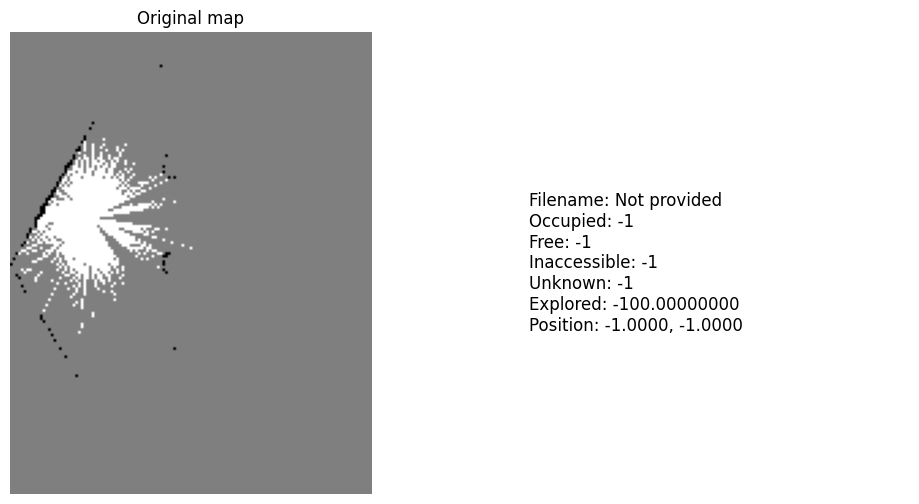

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [18]:
filenames = [_f.name for _f in os.scandir(DIRPATH) if _f.is_file()]
filenames.sort()

for _f in filenames:
    # print(_f)
    _grid, origin_x, origin_y = read_data_map(DIRPATH, _f)
    pos_x, pos_y = read_data_odom(DIRPATH, _f)
    position = (pos_x, pos_y)
    print_plot_v2(_grid, title="Original map")
    
    filled_grid = fill_enclosed_unknowns_v2(_grid, position)
    fully_enclosed = is_fully_enclosed(filled_grid, position)
    # print(fully_enclosed, _f)
    if fully_enclosed: filled_grid = fill_outside_with_100(filled_grid, position)
    
    filled_grid = mark_position(filled_grid, pos_x, pos_y, origin_x, origin_y)
    
    occupied,\
    free,\
    inaccessible,\
    unknown,\
    explored_percent = calculate_remaining_space(filled_grid)
    print_plot_v2(
        filled_grid,
        title=f"Filled map",
        filename=_f,
        occupied=occupied,
        free=free,
        inaccessible=inaccessible,
        unknown=unknown,
        explored_percent=explored_percent,
        position_x=pos_x,
        position_y=pos_y
    )
    
    # break
    
    # TODO create fucntion to fill outer space / not calculate the remaining outer space